# Plot the whole pipeline

This script is used for plotting figures showing the whole pipeline

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
from pathlib import Path
import sys
import json
import pandas as pd
import numpy as np
import os



PROJECT_ROOT = Path().home() 

# Patient flow package
USER_ROOT = Path().home() / 'work'
sys.path.append(str(USER_ROOT / 'patientflow' / 'src' / 'patientflow'))
sys.path.append(str(USER_ROOT / 'patientflow' / 'functions'))


In [3]:
model_file_path = PROJECT_ROOT /'data' / 'ed-predictor' / 'trained-models'
model_file_path

data_file_path = USER_ROOT / 'ed-predictor' / 'data-raw'
data_file_path

media_file_path = USER_ROOT / 'patientflow' / 'notebooks' / 'img'
media_file_path.mkdir(parents=True, exist_ok=True)

## Load parameters

These are set in config.json. You can change these for your own purposes. But the times of day will need to match those in the provided dataset if you want to run this notebook successfully.

In [7]:
# Load the times of day
import yaml

config_path = Path(USER_ROOT / 'patientflow')

with open(config_path / 'config.yaml', 'r') as file:
    config = yaml.safe_load(file)
    
# Convert list of times of day at which predictions will be made (currently stored as lists) to list of tuples
prediction_times = [tuple(item) for item in config['prediction_times']]


# Load the dates defining the beginning and end of training, validation and test sets
start_training_set, start_validation_set, start_test_set, end_test_set = [item for item in config['modelling_dates']]

x1 = float(config['x1'])
y1 = float(config['y1'])
x2 = float(config['x2'])
y2 = float(config['y2'])

prediction_window = config['prediction_window']
# prediction_window = 480

# Load data and select snapshot to plot

In [9]:
from ed_admissions_data_retrieval import ed_admissions_get_data
path_admission_data = str(data_file_path) + '/ed_visits.csv'
path_spec_data = str(data_file_path) + '/specialty.csv'

df = ed_admissions_get_data(path_admission_data)
df_spec = ed_admissions_get_data(path_spec_data)

if df.index.name != 'snapshot_id':
    df = df.set_index('snapshot_id')
df.head()

if df_spec.index.name != 'snapshot_id':
    df_spec = df_spec.set_index('snapshot_id')
df_spec.head()

,visit_number,consultation_sequence,final_sequence,specialty
snapshot_id,,,,
7,6,[CON47],[CON47],haem/onc
8,7,[CON47],[CON47],haem/onc
11,9,[CON47],[CON47],haem/onc
14,12,[CON57],[CON57],haem/onc
19,323,[CON15],[CON15],paediatric


In [10]:
df.head()

,snapshot_date,prediction_time,visit_number,training_validation_test,elapsed_los_td,sex,arrival_method,current_location_type,total_locations_visited,num_obs,...,latest_lab_results_lac,latest_lab_results_na,latest_lab_results_pco2,latest_lab_results_ph,latest_lab_results_wcc,latest_lab_results_hco3,has_consultation,is_admitted,age_group,random_number
snapshot_id,,,,,,,,,,,,,,,,,,,,,
0,2030-04-09,"(12, 0)",1,train,3420.0,F,Walk-in,waiting,2,14,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,45-54,121958
1,2030-04-09,"(15, 30)",1,train,16020.0,F,Walk-in,majors,5,30,...,0.5,141.0,6.84,7.371,5.28,NaN,False,False,45-54,146867
2,2030-08-08,"(15, 30)",2,train,29760.0,M,NaN,majors,3,67,...,0.9,142.0,6.31,7.361,5.53,NaN,True,False,65-74,131932
3,2030-08-03,"(12, 0)",3,train,106800.0,M,Walk-in,majors,5,405,...,1.3,NaN,5.83,7.434,NaN,NaN,False,False,65-74,259178
4,2030-04-24,"(12, 0)",4,train,6600.0,F,Walk-in,sdec_waiting,4,14,...,NaN,NaN,NaN,NaN,NaN,NaN,True,False,35-44,119879


In [23]:
# pick a random snapshot_date and time of day in the test set
prediction_time_ = prediction_times[3]
random_snapshot_date = df.loc[df.training_validation_test == 'test', 'snapshot_date'].sample(n=1, random_state=42).iloc[0]

hour_, min_ = prediction_time_
min_ = f"{min_}0" if min_ % 60 == 0 else str(min_)
snapshot_datetime = random_snapshot_date + '_'+ str(hour_) + '-' + str(min_ )

# create folder to save the plots in
full_file_path = media_file_path / 'pipeline_figures' /snapshot_datetime / 'full'
pipeline_file_path = media_file_path / 'pipeline_figures' /snapshot_datetime / 'minimal'
os.makedirs(pipeline_file_path, exist_ok=True)
os.makedirs(full_file_path, exist_ok=True)

# get the data for this random time
ex = df[(df.snapshot_date == random_snapshot_date) & (df.prediction_time == prediction_time_) & (df.current_location_type != 'OTF')].copy()

# reduce number of locations for presentation purposes
mapping = {'utc': 'Minors', 
           'majors': 'Majors/Resus', 
           'sdec': 'Other', 
           'paeds': 'Other', 
           'waiting': 'Other', 
           'rat': 'Majors/Resus', 
           'sdec_waiting': 'Other', 
           'resus' : 'Majors/Resus',
            'taf' : 'Other'}

categories = ['Majors/Resus', 'Minors', 'Other']  # Define order

ex['loc_new'] = ex['current_location_type'].map(mapping)
ex['loc_new'] = pd.Categorical(ex['loc_new'], categories=categories, ordered=True)


In [18]:
full_file_path

PosixPath('/home/jovyan/work/patientflow/notebooks/img/pipeline_figures/2032-01-24_15-30/full')

## Set up plot

In [15]:
# set plot parameters
figsize_global = tuple([6,3])
full_output = True

from plot_pipeline import create_colour_dict
spec_colour_dict = create_colour_dict()

## Figure a

In [22]:
ex.current_location_type.value_counts()

current_location_type
utc             21
majors          12
sdec             9
sdec_waiting     5
paeds            5
waiting          5
rat              2
taf              1
resus            1
Name: count, dtype: int64

/home/jovyan/work/patientflow/functions/plot_pipeline.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for location, group in ex.groupby('loc_new'):


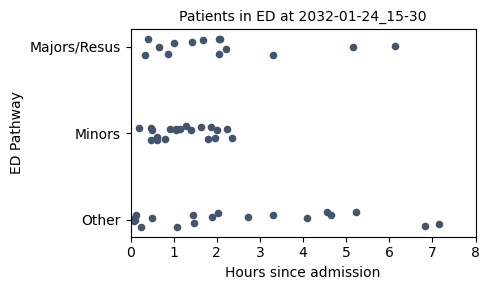

In [24]:
from plot_pipeline import in_ED_now_plot

title_ = f'Patients in ED at {snapshot_datetime}' 
if full_output:    
    in_ED_now_plot(full_file_path, 'Full Figure a', ex, snapshot_datetime, figsize_global, title_, include_titles = True, size = 20)
else:
    in_ED_now_plot(pipeline_file_path, 'Figure a', ex, snapshot_datetime, figsize_global, title_, text_size= 20)

## Figure b

/home/jovyan/work/patientflow/functions/plot_pipeline.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for location, group in ex.groupby('loc_new'):


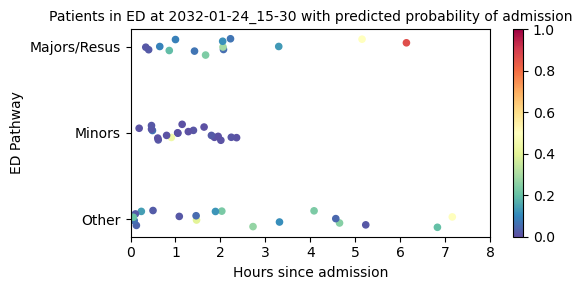

In [35]:
from ed_admissions_helper_functions import prepare_for_inference
from predict.emergency_demand.from_individual_probs import model_input_to_pred_proba

# load saved model
model = prepare_for_inference(model_file_path = model_file_path, model_name = 'ed_admission', prediction_time = prediction_time_, data_path = None, single_snapshot_per_visit = False, model_only = True)

# get probabilities
episode_slices_in_ex = ex.index[(ex.snapshot_date == random_snapshot_date)]
preds = model_input_to_pred_proba(ex, model)
ex['preds'] = preds['pred_proba'].values

title = f'Patients in ED at {snapshot_datetime}' 
if full_output:
    in_ED_now_plot(full_file_path, 'Full Figure b', ex, snapshot_datetime, figsize_global, title_, include_titles = True, size = 20, colour = True, colour_map = 'Spectral_r')# spec_colour_dict['spectrum']['all'])
else:
    in_ED_now_plot(pipeline_file_path, 'Figure b', ex, snapshot_datetime, figsize_global, title_, text_size= 20, colour = True, colour_map = 'Spectral_r')


## Figure c

In [44]:
import datetime
df['snapshot_date'] = pd.to_datetime(df['snapshot_date']).dt.date
df['snapshot_datetime'] = df.apply(lambda row: datetime.datetime.combine(
    row['snapshot_date'], 
    datetime.time(row['prediction_time'][0], row['prediction_time'][1])
).replace(tzinfo=datetime.timezone.utc), axis=1)

Calculating probability distributions for 1 horizon dates
Processed 1 horizon dates


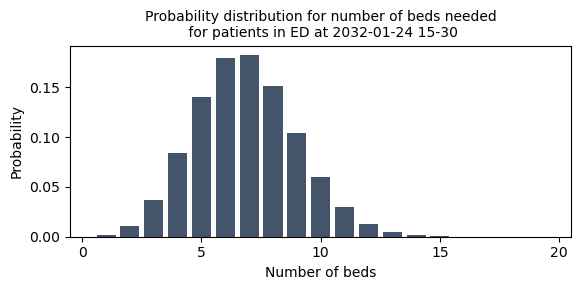

In [47]:
df = ed_admissions_get_data(path_admission_data)
from predict.emergency_demand.from_individual_probs import get_prob_dist
from viz.prob_dist_plot import prob_dist_plot

from ed_admissions_helper_functions import prepare_for_inference


from ed_admissions_helper_functions import prepare_snapshots_dict


# prepare data 
X_test, y_test, model = prepare_for_inference(model_file_path, 'ed_admission', prediction_time = prediction_time_, data_path = path_admission_data, single_snapshot_per_visit = False)


episode_slices_dict = prepare_snapshots_dict(df[(df.training_validation_test == 'test') & (df.prediction_time == prediction_time_) & (df.snapshot_date == random_snapshot_date)])
prob_dist = get_prob_dist(
    episode_slices_dict, X_test, y_test, model
)

if full_output:

    title_ = f'Probability distribution for number of beds needed\n for patients in ED at {random_snapshot_date} {hour_}-{min_}'
    prob_dist_plot(prob_dist_data=prob_dist[random_snapshot_date]['pred_demand'], title_=title_, directory_path=full_file_path, figsize=figsize_global, include_titles=True, 
                   file_name = 'Full Figure c',
                  bar_colour = spec_colour_dict['single']['all'])
else:
    title_ = 'Figure c'
    prob_dist_plot(prob_dist_data=prob_dist[random_snapshot_date]['pred_demand'], title_=title_, directory_path=pipeline_file_path, figsize=figsize_global, text_size=20, file_name = 'Figure c',
                  bar_colour = spec_colour_dict['single']['all'])


### Figure d - currently done in powerpoint

In [ ]:
specialty_model = prepare_for_inference(model_file_path, 'ed_specialty', model_only=True)

weights = specialty_model.weights
weights[tuple(['surgical'])]

In [ ]:
# df_admitted_with_spec = df[(df.is_admitted)].merge(df_spec[['episode_slice_id','consultation_sequence', 'observed_specialty']] , on='episode_slice_id', how='left')
# df_admitted_with_spec.loc[df_admitted_with_spec.consultation_sequence.isnull(), 'consultation_sequence'] = 'None'

# spec_dict = {}
# spec_dict['-'] = spec_dict = {'-': {k[0].upper(): v for k, v in df_admitted_with_spec[df_admitted_with_spec.consultation_sequence == 'None']['observed_specialty'].value_counts(normalize=True).to_dict().items()}}


# spec_dict['-']['-m'] = {k[0].upper(): v for k, v in df_admitted_with_spec[df_admitted_with_spec.consultation_sequence == "('medical',)"]['observed_specialty'].value_counts(normalize=True).to_dict().items()}
# spec_dict['-']['-s'] = {k[0].upper(): v for k, v in df_admitted_with_spec[df_admitted_with_spec.consultation_sequence == "('surgical',)"]['observed_specialty'].value_counts(normalize=True).to_dict().items()}
# spec_dict['-']['-h'] = {k[0].upper(): v for k, v in df_admitted_with_spec[df_admitted_with_spec.consultation_sequence == "('haem/onc',)"]['observed_specialty'].value_counts(normalize=True).to_dict().items()}
# spec_dict#['-']['-m'].keys()


### Figure e - NOTE currently there is no data on consults for discharged patients

Possible fixes - save consults data with original df. 

In [32]:
ex[(ex.has_consultation) & (ex.is_admitted)].index

df_spec[ex[(ex.has_consultation) & (ex.is_admitted)].index]

KeyError: "None of [Index([234260, 234283, 234316], dtype='int64', name='snapshot_id')] are in the [columns]"

In [59]:
spec

,age_group,consultation_sequence,specialty
snapshot_id,,,
233440,25-34,(),NaN
233580,65-74,(),NaN
233975,45-54,(),NaN
233988,25-34,(),NaN
234004,75-102,(),NaN
...,...,...,...
234388,35-44,(),NaN
234389,25-34,(),NaN
234390,35-44,(),NaN


/tmp/ipykernel_25647/3942186132.py:22: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  spec['consultation_sequence'] = spec['consultation_sequence'].apply(lambda x: () if pd.isna(x) else x)
/home/jovyan/work/patientflow/functions/plot_pipeline.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for location, group in ex.groupby('loc_new'):


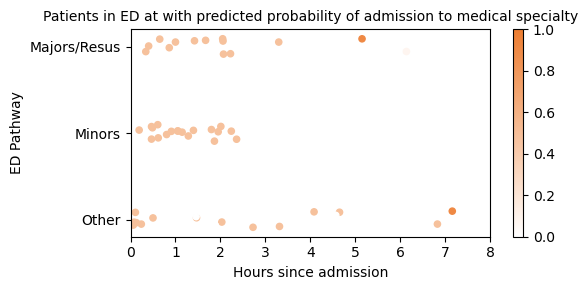

/home/jovyan/work/patientflow/functions/plot_pipeline.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for location, group in ex.groupby('loc_new'):


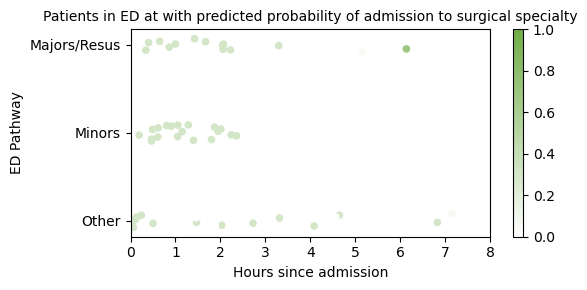

/home/jovyan/work/patientflow/functions/plot_pipeline.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for location, group in ex.groupby('loc_new'):


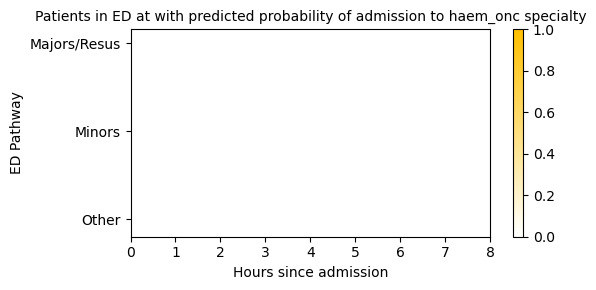

/home/jovyan/work/patientflow/functions/plot_pipeline.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for location, group in ex.groupby('loc_new'):


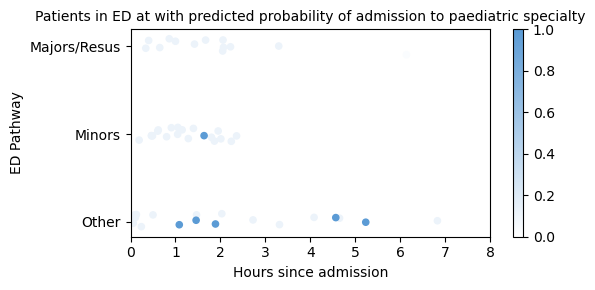

In [66]:
from ed_admissions_data_retrieval import ed_admissions_get_data
from ed_admissions_helper_functions import get_specialty_probs, prepare_snapshots_dict


child_age_group = '0-17'
child_dict = {
    'medical': 0.0,
    'surgical': 0.0,
    'haem/onc': 0.0,
    'paediatric': 1.0
}

X_test, y_test, model = prepare_for_inference(model_file_path, 'ed_admission', prediction_time = prediction_time_, data_path = path_admission_data, single_snapshot_per_visit = False)
episode_slices_dict = prepare_snapshots_dict(df[(df.training_validation_test == 'test') & (df.prediction_time == prediction_time_) & (df.snapshot_date == random_snapshot_date)])

is_child_func = lambda row: row['age_group'] == '0-17' # or row['age'] <= 17


spec = pd.merge(ex[['age_group']], df_spec[['consultation_sequence', 'specialty']], left_index=True, right_index=True, how='left')
# after merge, set NA values to empty tuple

spec['consultation_sequence'] = spec['consultation_sequence'].apply(lambda x: () if pd.isna(x) else x)
spec['consultation_sequence'] = spec['consultation_sequence'].apply(lambda x: tuple(x))

spec['specialty_prob'] = get_specialty_probs(model_file_path, spec, special_category_func=is_child_func, special_category_dict=child_dict)

specs =  ['medical', 'surgical', 'haem/onc', 'paediatric']
spec = spec.assign(**{f'{key}_prob': spec['specialty_prob'].apply(lambda d: d.get(key)) for key in specs})

# spec = pd.merge(ex['prob_admission_in_window'], spec, left_index=True, right_index=True, how='left')
ex_spec = pd.merge(ex, spec, left_index=True, right_index=True, how='left')

for spec_ in ['medical', 'surgical', 'haem/onc', 'paediatric']:

    if full_output:    
        title_ = 'Patients in ED at' 
        in_ED_now_plot(full_file_path, f'Full Figure e {spec_}', ex_spec, snapshot_datetime, figsize_global, title_, include_titles = True, colour = True, colour_map = spec_colour_dict['spectrum'][spec_], 
                       size = 20, preds_col = f'{spec_}_prob', title_suffix = f'admission to {spec_} specialty')
    else:
        title_ = 'Figure e' 
        in_ED_now_plot(pipeline_file_path, f'Figure e {spec_}', ex_spec, snapshot_datetime, figsize_global, title_, text_size= 20, colour = True, colour_map = spec_colour_dict['spectrum'][spec_], preds_col = f'{spec_}_prob')

## Figure f

'haem_onc'


Processing probability of admission to:medical
Calculating probability distributions for 1 horizon dates
Processed 1 horizon dates

Processing probability of admission to:surgical
Calculating probability distributions for 1 horizon dates
Processed 1 horizon dates

Processing probability of admission to:haem/onc
Calculating probability distributions for 1 horizon dates
Processed 1 horizon dates

Processing probability of admission to:paediatric
Calculating probability distributions for 1 horizon dates
Processed 1 horizon dates


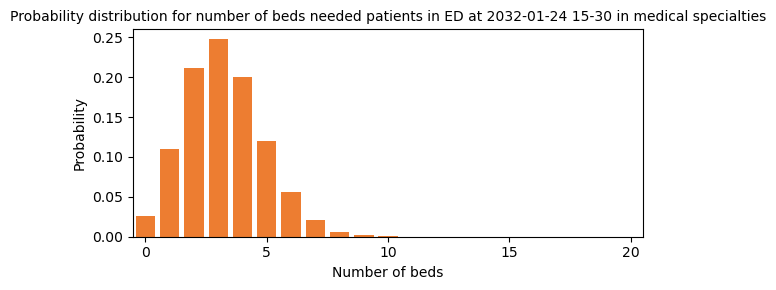

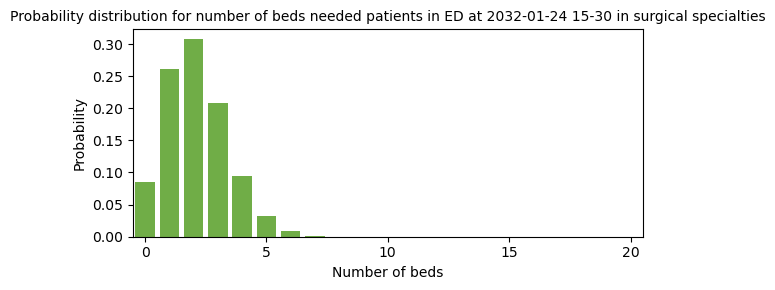

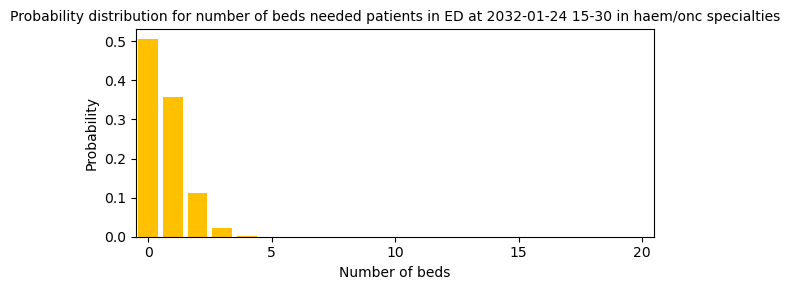

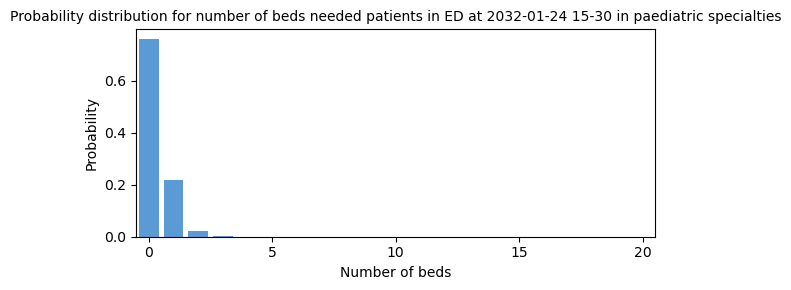

In [75]:
prob_dist_spec = {}
spec_colour_dict = create_colour_dict()

for spec_ in ['medical', 'surgical', 'haem/onc', 'paediatric']:
    print("\nProcessing probability of admission to:" + spec_ )

    # get the probability of admission to this specialty for all patients
    weights = spec['specialty_prob'].apply(lambda x: x.get(spec_))

    # select only the episode slices that pertain to children or adults, as appropriate
    if spec_ == 'paediatric':
        episode_slices_dict = prepare_snapshots_dict(ex_spec[ex_spec.age_group_x == '0-17'])
    else:
        episode_slices_dict = prepare_snapshots_dict(ex_spec[ex_spec.age_group_x != '0-17'])
        
    # get probability distribution for this time of day
    prob_dist_spec[spec_] = get_prob_dist(
        episode_slices_dict, X_test, y_test, model, weights
    )

for spec_ in ['medical', 'surgical', 'haem/onc', 'paediatric']:

    if full_output:

        title_ = f'Probability distribution for number of beds needed patients in ED at {random_snapshot_date} {hour_}-{min_} in {spec_} specialties'
        prob_dist_plot(prob_dist_data=prob_dist_spec[spec_][random_snapshot_date]['pred_demand'], title_=title_, directory_path=full_file_path, figsize=figsize_global, include_titles=True, 
                       bar_colour= spec_colour_dict['single'][spec_], file_name = f'Full Figure f {spec_.replace("/", "_")}')
    else:
        title_ = 'Figure f'
        prob_dist_plot(prob_dist_data=prob_dist_spec[spec_][random_snapshot_date]['pred_demand'], title_=title_, directory_path=pipeline_file_path, figsize=figsize_global, text_size=20, 
                       bar_colour= spec_colour_dict['single'][spec_], file_name = f'Figure f {spec_.replace("/", "_")}')

## Figure g 

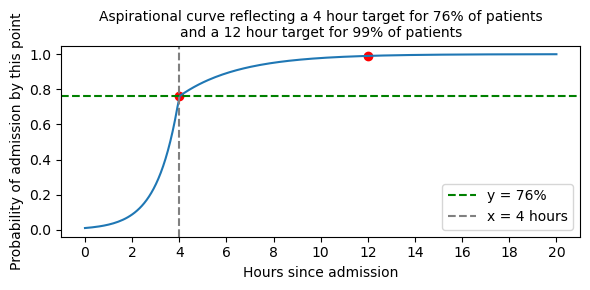

In [76]:

from predict.emergency_demand.admission_in_prediction_window_using_aspirational_curve import calculate_probability
from viz.aspirational_curve_plot import plot_curve

prediction_window_hrs = prediction_window/60
ex_spec['elapsed_los_td_hrs'] = ex_spec['elapsed_los_td']/3600

ex_spec['prob_adm_in_window'] = ex_spec.apply(lambda row: calculate_probability(row['elapsed_los_td_hrs'], prediction_window_hrs, x1 = 4, y1 = 0.76, x2 = 12, y2 = .99), axis=1)


directory_path = media_file_path / snapshot_datetime

if full_output:

    title_ = 'Aspirational curve reflecting a 4 hour target for 76% of patients\nand a 12 hour target for 99% of patients'
    plot_curve(full_file_path, figsize_global, title_, x1 = 4, y1 = .76, x2 = 12, y2 = 0.99, include_titles = True, file_name = 'Full Figure g')
    
else:
    
    title_ = 'Figure g'
    plot_curve(pipeline_file_path, figsize_global, title_, x1 = 4, y1 = .76, x2 = 12, y2 = 0.99,  text_size = 20, file_name = 'Figure g')

## Figure h

/home/jovyan/work/patientflow/functions/plot_pipeline.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for location, group in ex.groupby('loc_new'):


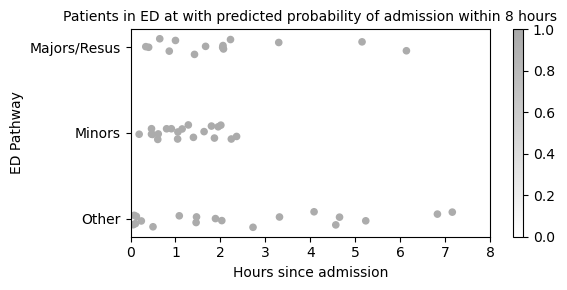

In [77]:
if full_output:    
    title_ = 'Patients in ED at' 
    in_ED_now_plot(full_file_path, 'Full figure h', ex_spec, snapshot_datetime, figsize_global, title_, include_titles = True, colour = True, colour_map = spec_colour_dict['spectrum']['window'], size = 20, preds_col = 'prob_adm_in_window', 
                   title_suffix = 'admission within ' + str(int(prediction_window_hrs)) + ' hours')
else:
    title_ = 'Figure h' 
    in_ED_now_plot(pipeline_file_path, 'Figure h', ex_spec, snapshot_datetime,  figsize_global, title_, text_size= 20, colour = True, colour_map = spec_colour_dict['spectrum']['window'], preds_col = 'prob_adm_in_window')

## Figure i



Processing probability of admission to:medical
Calculating probability distributions for 1 horizon dates
Processed 1 horizon dates

Processing probability of admission to:surgical
Calculating probability distributions for 1 horizon dates
Processed 1 horizon dates

Processing probability of admission to:haem/onc
Calculating probability distributions for 1 horizon dates
Processed 1 horizon dates

Processing probability of admission to:paediatric
Calculating probability distributions for 1 horizon dates
Processed 1 horizon dates


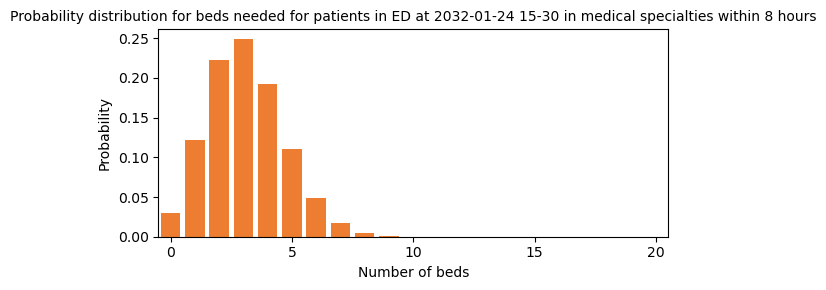

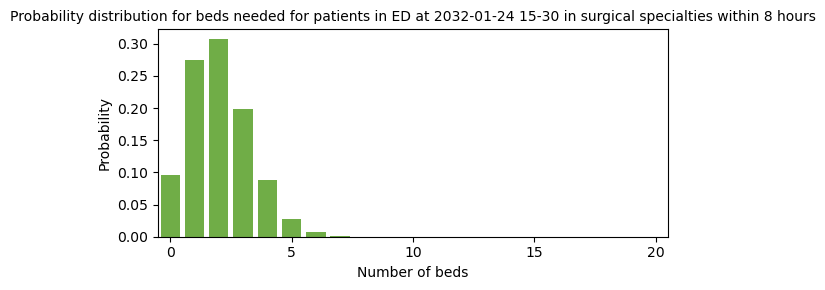

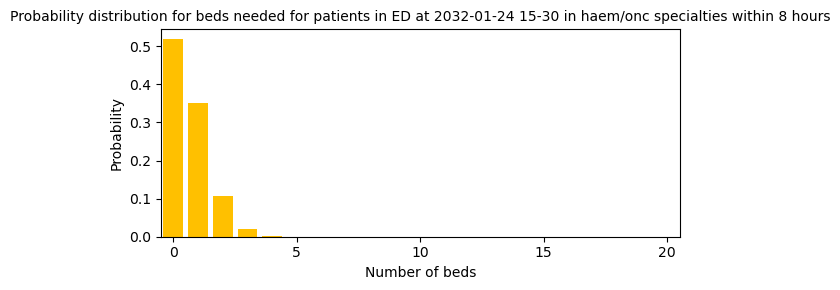

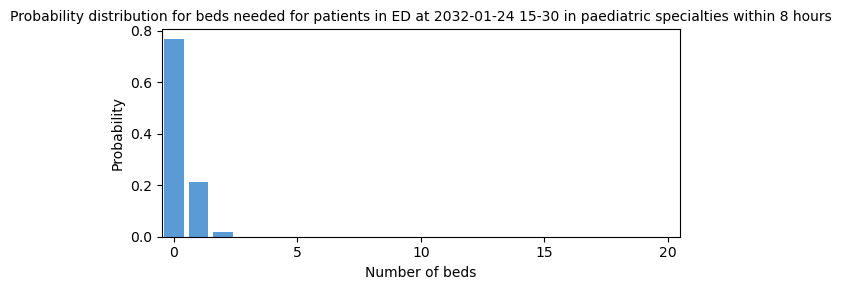

In [79]:
prob_dist_spec_in_window = {}

for spec_ in ['medical', 'surgical', 'haem/onc', 'paediatric']:
    print("\nProcessing probability of admission to:" + spec_ )

    # get the probability of admission to this specialty for all patients
    weights = ex_spec['specialty_prob'].apply(lambda x: x.get(spec_))
    
    # multiply by probability of admission in window
    weights_in_window = weights * ex_spec['prob_adm_in_window']

    # select only the episode slices that pertain to children or adults, as appropriate
    if spec_ == 'paediatric':
        episode_slices_dict = prepare_snapshots_dict(ex_spec[ex_spec.age_group_x == '0-17'])
    else:
        episode_slices_dict = prepare_snapshots_dict(ex_spec[ex_spec.age_group_x != '0-17'])
        
    # get probability distribution for this time of day
    prob_dist_spec_in_window[spec_] = get_prob_dist(
        episode_slices_dict, X_test, y_test, model, weights_in_window
    )


for spec_ in ['medical', 'surgical', 'haem/onc', 'paediatric']:

    if full_output:
        title_ = f'Probability distribution for beds needed for patients in ED at {random_snapshot_date} {hour_}-{min_} in {spec_} specialties within {str(int(prediction_window_hrs))} hours'
        prob_dist_plot(prob_dist_data=prob_dist_spec_in_window[spec_][random_snapshot_date]['pred_demand'], title_=title_, directory_path=full_file_path, figsize=figsize_global, include_titles=True, 
                       bar_colour=spec_colour_dict['single'][spec_], file_name = f'Full Figure i {spec_.replace("/", "_")}')

    else: 
        title_ = f'Figure i {spec_}'
        prob_dist_plot(prob_dist_data=prob_dist_spec_in_window[spec_][random_snapshot_date]['pred_demand'], title_=title_, directory_path=pipeline_file_path, figsize=figsize_global, text_size=20,
                           bar_colour=spec_colour_dict['single'][spec_], file_name = f'Figure i {spec_.replace("/", "_")}')

## Figure j

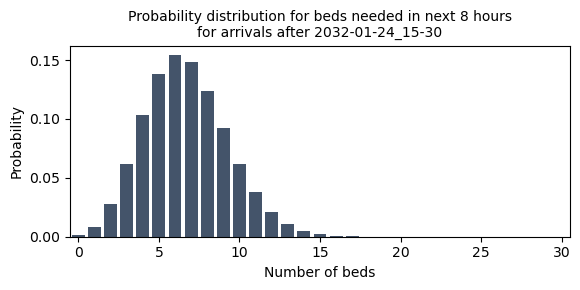

In [80]:
from joblib import load
prediction_window = 480
MODEL__ED_YETTOARRIVE__NAME = 'ed_yet_to_arrive_all_' + str(int(prediction_window/60)) + '_hours'
full_path = model_file_path / MODEL__ED_YETTOARRIVE__NAME 
full_path = full_path.with_suffix('.joblib')

# only medical patients
prediction_context = {
    'default': {
        'prediction_time': prediction_time_ 
    }
}

model = load(full_path)
prob_dist_yta = model.predict(prediction_context, x1, y1, x2, y2)

if full_output:

    title_ = f'Probability distribution for beds needed in next {int(prediction_window/60)} hours\nfor arrivals after {snapshot_datetime}'
    prob_dist_plot(prob_dist_yta['default'],figsize=figsize_global, title_=title_, directory_path=full_file_path, include_titles = True, truncate_at_beds=30, 
                   bar_colour = spec_colour_dict['single']['all'], file_name = f'Full Figure j')
    
else: 

    title_ = 'Figure j all' 
    prob_dist_plot(prob_dist_yta['default'],figsize=figsize_global, title_=title_, directory_path=pipeline_file_path, text_size = 20,  truncate_at_beds=30, 
                   bar_colour = spec_colour_dict['single']['all'], file_name = f'Figure j')

    


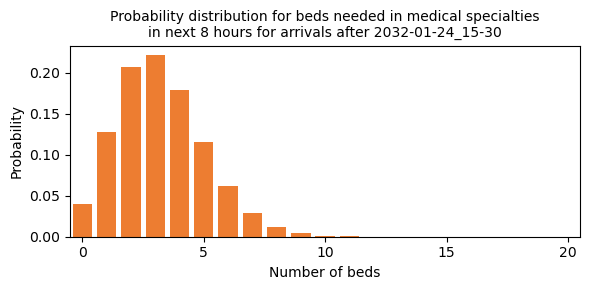

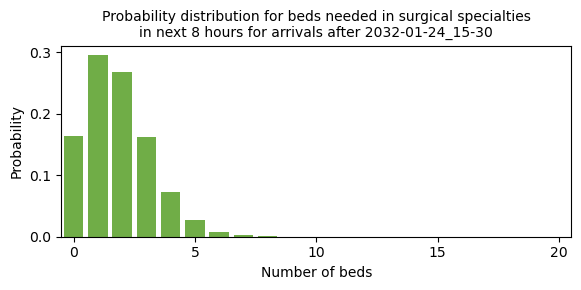

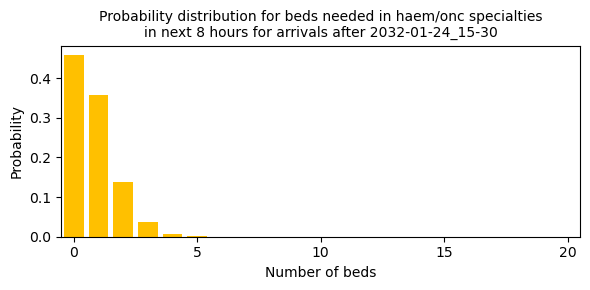

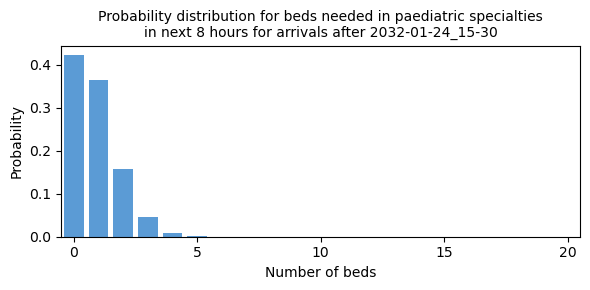

In [82]:

MODEL__ED_YETTOARRIVE__NAME = 'ed_yet_to_arrive_by_spec_' + str(int(prediction_window/60)) + '_hours'
full_path = model_file_path / MODEL__ED_YETTOARRIVE__NAME 
full_path = full_path.with_suffix('.joblib')

model_by_spec = load(full_path)

for spec_ in ['medical', 'surgical', 'haem/onc', 'paediatric']:

    prediction_context = {
        spec_: {
            'prediction_time': prediction_time_ 
        }
    }

    model = load(full_path)
    prob_dist_yta_spec = model.predict(prediction_context, x1, y1, x2, y2)
    
    if full_output:

        title_ = f'Probability distribution for beds needed in {spec_} specialties\nin next {int(prediction_window/60)} hours for arrivals after {snapshot_datetime}'
        prob_dist_plot(prob_dist_yta_spec[spec_],figsize=figsize_global, title_=title_, directory_path=full_file_path, include_titles = True, truncate_at_beds=20, 
                    bar_colour = spec_colour_dict['single'][spec_], file_name = f'Full Figure j {spec_.replace("/", "_")}')
        
    else:

        title_ = 'Figure g' 
        prob_dist_plot(prob_dist_yta_spec[spec_],figsize=figsize_global, title_=title_, directory_path=pipeline_file_path, text_size = 20,  truncate_at_beds=20, 
                       bar_colour = spec_colour_dict['single'][spec_], file_name = f'Figure j {spec_.replace("/", "_")}')
